<a href="https://colab.research.google.com/github/TFZAI/TFZAI/blob/main/Weights_only_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install brevitas 

     |████████████████████████████████| 393 kB 5.0 MB/s 


In [57]:
import torch
import torchvision
import torchvision.transforms as transforms

In [58]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [59]:
import matplotlib.pyplot as plt
import numpy as np

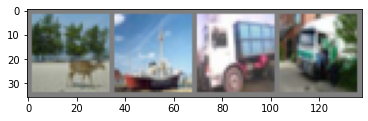

 deer  ship truck truck


In [60]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [61]:
from torch import nn
from torch.nn import Module
import torch.nn.functional as F

import brevitas.nn as qnn


class QuantWeightLeNet(Module):
    def __init__(self):
        super(QuantWeightLeNet, self).__init__()
        self.conv1 = qnn.QuantConv2d(3, 6, 5, weight_bit_width=3)
        self.relu1 = nn.ReLU()
        self.conv2 = qnn.QuantConv2d(6, 16, 5, weight_bit_width=3)
        self.relu2 = nn.ReLU()
        self.fc1   = qnn.QuantLinear(16*5*5, 120, bias=True, weight_bit_width=3)
        self.relu3 = nn.ReLU()
        self.fc2   = qnn.QuantLinear(120, 84, bias=True, weight_bit_width=3)
        self.relu4 = nn.ReLU()
        self.fc3   = qnn.QuantLinear(84, 10, bias=False, weight_bit_width=3)

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = self.relu2(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.reshape(out.shape[0], -1)
        out = self.relu3(self.fc1(out))
        out = self.relu4(self.fc2(out))
        out = self.fc3(out)
        return out

quant_weight_lenet = QuantWeightLeNet()

In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [63]:
for epoch in range(10):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.745
[1,  4000] loss: 0.807
[1,  6000] loss: 0.824
[1,  8000] loss: 0.822
[1, 10000] loss: 0.839
[1, 12000] loss: 0.858
[2,  2000] loss: 0.731
[2,  4000] loss: 0.751
[2,  6000] loss: 0.801
[2,  8000] loss: 0.788
[2, 10000] loss: 0.821
[2, 12000] loss: 0.840
[3,  2000] loss: 0.692
[3,  4000] loss: 0.747
[3,  6000] loss: 0.766
[3,  8000] loss: 0.800
[3, 10000] loss: 0.802
[3, 12000] loss: 0.832
[4,  2000] loss: 0.688
[4,  4000] loss: 0.730
[4,  6000] loss: 0.746
[4,  8000] loss: 0.749
[4, 10000] loss: 0.777
[4, 12000] loss: 0.800
[5,  2000] loss: 0.693
[5,  4000] loss: 0.701
[5,  6000] loss: 0.723
[5,  8000] loss: 0.765
[5, 10000] loss: 0.746
[5, 12000] loss: 0.771
[6,  2000] loss: 0.656
[6,  4000] loss: 0.681
[6,  6000] loss: 0.715
[6,  8000] loss: 0.724
[6, 10000] loss: 0.770
[6, 12000] loss: 0.751
[7,  2000] loss: 0.647
[7,  4000] loss: 0.668
[7,  6000] loss: 0.737
[7,  8000] loss: 0.748
[7, 10000] loss: 0.723
[7, 12000] loss: 0.737
[8,  2000] loss: 0.623
[8,  4000] 

In [64]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [65]:
dataiter = iter(testloader)
images, labels = dataiter.next()



In [67]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [68]:
outputs = net(images)

In [69]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
      
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    150* correct / total))

Accuracy of the network on the 10000 test images: 91 %


In [56]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
     
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1



for classname, correct_count in correct_pred.items():
    accuracy = 130 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 91.8 %
Accuracy for class car   is: 98.8 %
Accuracy for class bird  is: 57.9 %
Accuracy for class cat   is: 55.0 %
Accuracy for class deer  is: 78.9 %
Accuracy for class dog   is: 61.2 %
Accuracy for class frog  is: 99.2 %
Accuracy for class horse is: 95.9 %
Accuracy for class ship  is: 98.0 %
Accuracy for class truck is: 84.2 %
